# Useful Flags

In [1]:
quantile_normalisation_flag = False
simple_normalisation_flag = True
steve_scaling_flag = False
use_deltas = True

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
df = pd.read_pickle('female_test.pkl')
dft = pd.read_pickle('female_train.pkl')
from scipy.stats import pearsonr
from sklearn.decomposition import FastICA
from scipy import linalg
from datetime import datetime

In [3]:
df.head()

,modality,dataframe
0,T1_nonlinear,Unnamed: 0 target_age output_age_1 ag...
1,T1_linear,Unnamed: 0 target_age output_age_1 ag...
2,jacobian,Unnamed: 0 target_age output_age_1 ag...
3,vbm,Unnamed: 0 target_age output_age_1 ag...
4,T2_nonlinear,Unnamed: 0 target_age output_age_1 ag...


In [4]:
df.iloc[0].dataframe.head()

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,loss_3,mean_output_age,mean_age_delta,output_age_decon,age_delta_decon
0,24806531,67.670662,64.333970,-3.336693,11.133520,68.213356,0.542694,0.294517,69.064550,1.393890,1.942930,67.203959,-0.466703,67.759970,0.089308
1,24237795,77.280936,76.549820,-0.731116,0.534531,80.026930,2.745996,7.540492,73.370640,-3.910292,15.290387,76.649130,-0.631806,78.834010,1.553074
2,24748274,58.301941,58.474884,0.172943,0.029909,57.800220,-0.501720,0.251723,58.086678,-0.215263,0.046338,58.120594,-0.181347,57.110133,-1.191808
3,25463415,58.056694,61.464960,3.408264,11.616265,61.611057,3.554363,12.633498,59.947334,1.890640,3.574521,61.007784,2.951090,60.495233,2.438539
4,25313661,59.653082,60.595932,0.942850,0.888966,60.810764,1.157682,1.340228,60.452370,0.799287,0.638861,60.619689,0.966606,60.040209,0.387127


In [5]:
df_test = {}
M = []

for idx in range(len(df)):
    name = df.iloc[idx].modality
    if use_deltas == False:
        data = df.iloc[idx].dataframe.output_age_decon.to_list()
    else:
        data = df.iloc[idx].dataframe.age_delta_decon.to_list()
    df_test[name] = data
    M.append(data)
    
df_test = pd.DataFrame.from_dict(df_test)
# df_test['target_age'] = df.iloc[0].dataframe.target_age.to_list()
target_ages = np.array(df.iloc[0].dataframe.target_age.to_list())

<AxesSubplot:ylabel='Density'>

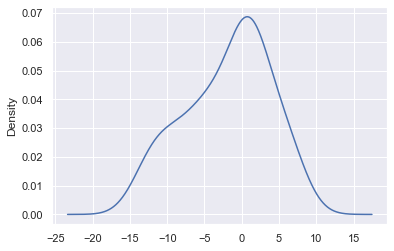

In [6]:
df_test.T[100].plot.density()

# Useful Functions

In [7]:
def quantile_normalisation(df):
    """
    Source: https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
    """
    df_sorted = pd.DataFrame(np.sort(df.values, axis=0), 
                             index=df.index, 
                             columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn =df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return df_qn

# Define the input M Matrix

M is a matrix of dimensions subjects x predicted ages.

M is the input matrix to FastICA

In [8]:
print(np.array(M).shape)

(57, 5022)


In [9]:
M = np.array(M).T

from scipy.io import savemat
Md = {'M':M, 'label':'M'}
if use_deltas == True:
    savemat("ICA/M_deltas.mat", Md)
else:
    savemat("ICA/M.mat", Md)

In [10]:
M

array([[ 0.08930815,  2.40666894,  1.11293997, ...,  1.84249064,
         6.513517  ,  0.43585467],
       [ 1.55307392,  0.46105457,  1.43288863, ...,  2.59800937,
         3.8170888 ,  2.78564804],
       [-1.19180805, -2.26309148, -7.59693665, ...,  3.12188481,
        -3.82266137, -4.96415397],
       ...,
       [-2.0964925 , -1.82805739, -9.98188998, ..., -3.41824137,
        -1.57092165, -5.75481278],
       [-0.43062102,  0.73280045,  2.78583951, ..., -4.0644654 ,
        -1.994143  , -6.7675373 ],
       [ 2.1249155 ,  1.86235452, -2.12317419, ..., -2.80866604,
        -2.03997829, -1.76483999]])

In [11]:
if quantile_normalisation_flag == True:
    df_qn = quantile_normalisation(df_test)
    M = df_qn.to_numpy()

if simple_normalisation_flag == True:
    M_mean, M_std = M.mean(axis=0), M.std(axis=0)
    M = (M - M.mean(axis=0)) / M.std(axis=0)
else:
    M_mean, M_std = None, None

if steve_scaling_flag == True:
    correlations = df_test.corr().target_age.to_numpy()[:-1]
    M = M * (0.1 + np.abs(correlations))

In [12]:
from scipy.io import savemat
Md = {'M':M, 'label':'M'}
if use_deltas == True:
    savemat("ICA/Mp_deltas.mat", Md)
else:
    savemat("ICA/Mp.mat", Md)

In [13]:
df_norm = (df_qn - df_qn.mean())/df_qn.std()

NameError: name 'df_qn' is not defined

Text(0.5, 1.0, 'Mine')

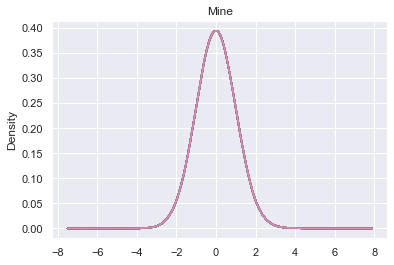

In [57]:
df_norm.plot.density(legend=False)
plt.title('Mine')

In [59]:
import scipy.io
if use_deltas == True:
    mat = scipy.io.loadmat('ICA/X_deltas_steve_preproc.mat')
else:
    mat = scipy.io.loadmat('ICA/X_steve_preproc.mat')
mat = pd.DataFrame.from_dict(mat['X'])
mat.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,0.044185,0.752204,0.217567,0.966957,0.206635,1.287815,2.189940,1.022493,0.369139,1.069070,...,0.865062,1.409098,0.936208,1.770111,0.706120,0.083698,0.837238,0.453544,1.521717,0.111782
1,0.497133,0.168528,0.280904,0.341153,0.127141,1.700313,0.970817,0.133180,0.931576,1.285534,...,1.294713,1.794364,0.029956,-0.156103,-0.365058,0.514718,-0.149033,0.637317,0.908844,0.720280
2,-0.369864,-0.702127,-1.492201,-0.803004,-0.085467,0.673038,-0.008983,0.145782,0.008986,0.412790,...,-1.777238,0.234048,-0.210716,-0.240111,-0.216034,0.383258,0.715114,0.776416,-0.888662,-1.224226
3,0.789982,0.810463,-1.516968,0.931711,1.135988,0.859267,-1.023334,0.064941,-0.666793,0.154872,...,0.068445,-0.031709,0.402482,1.019261,0.669446,0.053180,0.224728,0.240111,1.929963,0.334812
4,0.134917,-0.043443,-0.871751,-1.602862,-0.429152,-0.222985,-0.893719,0.918556,0.984501,-0.550208,...,-0.572415,-1.584883,-0.375024,-0.467974,-1.557638,-0.921743,-1.304114,-0.720280,0.119822,-1.028534


Text(0.5, 1.0, 'Steve')

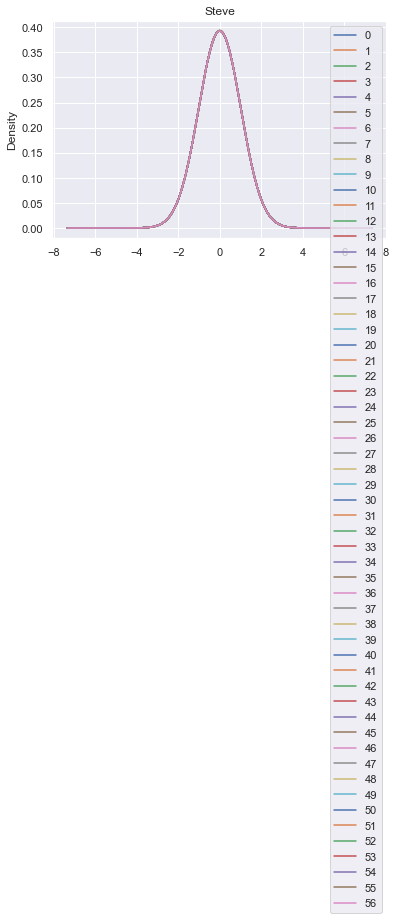

In [70]:
mat.plot.density()
plt.title('Steve')

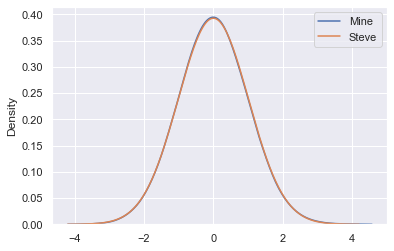

In [61]:
plt.figure()
sns.kdeplot(df_norm['T1_nonlinear'].to_numpy(), label='Mine')
sns.kdeplot(mat[0].to_numpy(), label='Steve')
plt.legend()

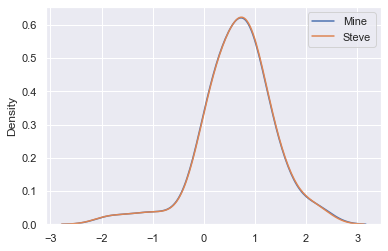

In [62]:
plt.figure()
sns.kdeplot(df_norm.iloc[0].to_numpy(), label='Mine')
sns.kdeplot(mat.iloc[0].to_numpy(), label='Steve')
plt.legend()

In [63]:
print('Mine Mean:', np.mean(df_norm.mean().to_numpy()))
print('Steve Mean:', np.mean(mat.mean().to_numpy()))

print('Mine Std:', np.mean(df_norm.std().to_numpy()))
print('Steve Std:', np.mean(mat.std().to_numpy()))

Mine Mean: -6.491865698436195e-18
Steve Mean: -7.02775898544923e-18
Mine Std: 1.0
Steve Std: 0.9995392809170784


<AxesSubplot:ylabel='Density'>

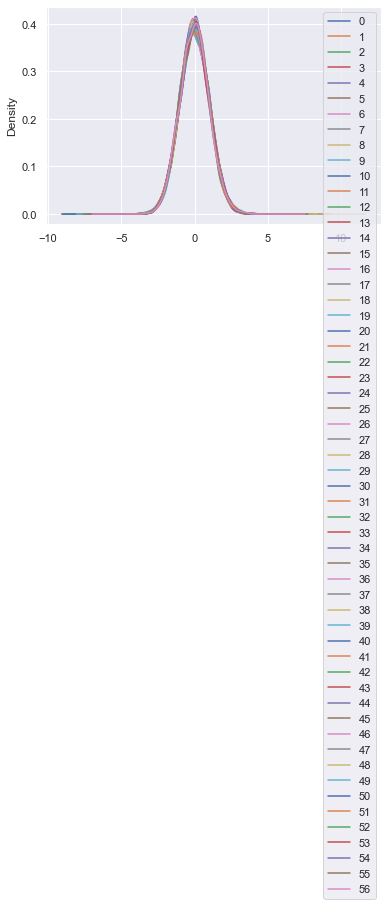

In [75]:
mat = scipy.io.loadmat('ICA/X_nets_normalised.mat')
mat = pd.DataFrame.from_dict(mat['X2'])
mat.head()
mat.plot.density()

<AxesSubplot:ylabel='Density'>

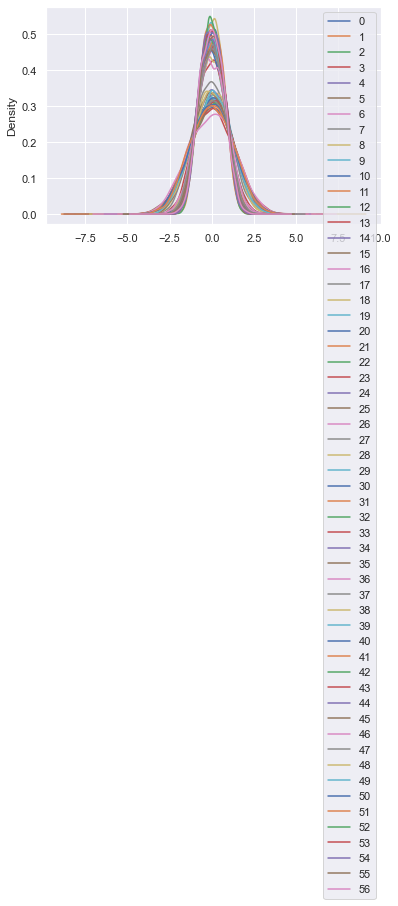

In [76]:
mat = scipy.io.loadmat('ICA/X_transp_nets_normalised.mat')
mat = pd.DataFrame.from_dict(mat['X2'])
mat.head()
mat.plot.density()

<AxesSubplot:ylabel='Density'>

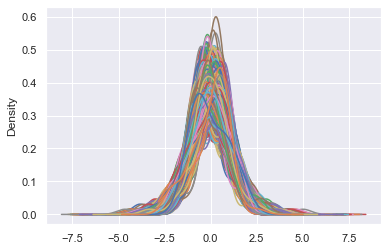

In [77]:
mat = scipy.io.loadmat('ICA/X_transp_nets_normalised.mat')
mat = pd.DataFrame.from_dict(mat['X2'])
mat.head()
mat.T.plot.density(legend=False)

In [78]:
df = pd.DataFrame({
...     'x': [1, 2, 2.5, 3, 3.5, 4, 5],
...     'y': [4, 4, 4.5, 5, 5.5, 6, 6],
... })
df

,x,y
0,1.0,4.0
1,2.0,4.0
2,2.5,4.5
3,3.0,5.0
4,3.5,5.5
5,4.0,6.0
6,5.0,6.0


In [79]:
mat

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,-0.759682,-0.249164,-0.527143,0.016077,-0.647398,1.208017,1.515513,0.852340,-0.162475,1.060686,...,0.115988,0.393127,-0.023369,0.806813,-0.145913,-0.704185,-0.013017,-0.369036,0.663863,-0.683389
1,-0.255792,-0.476208,-0.280447,-0.325368,-0.500880,1.782502,0.302110,-0.395545,0.868905,1.471506,...,0.634006,0.819225,-0.562705,-0.691379,-0.886461,-0.167377,-0.699049,-0.041411,0.207314,-0.003305
2,-0.172032,-0.408221,-1.566375,-0.546202,0.030613,1.110000,0.079090,0.295615,0.079316,0.791609,...,-1.672767,0.272533,-0.094981,-0.121179,-0.121631,0.410180,0.712410,0.767933,-0.741527,-0.995824
3,0.299190,0.323718,-1.838107,0.511141,0.484312,1.041075,-1.188253,-0.128755,-1.254925,0.039531,...,-0.160022,-0.252878,0.090106,0.619544,0.347898,-0.176604,-0.025575,-0.010940,1.530866,0.056745
4,0.194525,0.057036,-1.015439,-1.348609,-0.210257,-0.308587,-0.899594,1.731625,1.963292,-0.990060,...,-0.565307,-1.383222,-0.256093,-0.359588,-1.424021,-0.833997,-1.226600,-0.620542,0.235792,-0.937822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5017,0.251717,-0.271085,-1.576136,0.564913,0.677858,0.940386,1.711380,-1.690034,-0.571139,1.588475,...,-1.029918,0.546600,1.381685,0.122498,0.465539,0.577396,1.235337,0.820119,0.918887,0.333786
5018,0.776769,0.504272,-0.701595,-0.862694,-0.349529,0.555447,-0.799137,1.764457,0.821117,0.467160,...,-0.401519,-0.410628,0.574183,0.415596,-0.066245,-0.350526,0.279688,-0.187248,-0.572693,0.017368
5019,1.256358,1.346238,-1.338734,1.491171,-0.369616,0.312312,0.541624,-0.396478,0.231065,0.092561,...,0.083414,0.561947,0.142898,1.111053,0.054789,-0.616200,-1.023529,0.823766,1.429694,0.055367
5020,-0.430208,-0.183423,0.258323,-1.062538,-0.457477,-0.163115,-1.200289,1.473966,-0.577192,0.868964,...,-1.691176,-0.886651,-0.823487,-0.848895,-1.148921,-0.672544,-0.564902,-1.212193,-0.764694,-1.790195


# Simple ICA Implementation

Fit ICA where:

M = B G

M = subjects x predicted_ages

B = subjects x ICA_components = subject-weights vector = one scalar weight per subject

G = ICA_components x predicted_ages = ICA-source-vectirs = one scalar weight per modality

In [64]:
# ICA = FastICA(n_components=5, max_iter=10000, tol=1e-2, random_state=0)
ICA = FastICA(
    n_components = 5,
    tol = 1e-13,
    max_iter = 3000,   
)
ICA.fit(M.T)
G = ICA.mixing_.T
B = ICA.transform(M.T)
# M ~ np.dot(B,G) + ICA.mean_ = ICA.inverse_transform(B)
print('M shape: {}, B shape: {}, G shape: {}'.format(M.T.shape, B.shape, G.shape))

M shape: (57, 5022), B shape: (57, 5), G shape: (5, 5022)


In [65]:
# ICA = FastICA(n_components=5, max_iter=10000, tol=1e-2, random_state=0)
ICA = FastICA(
    n_components = 5,
    tol = 1e-13,
    max_iter = 3000,   
)
ICA.fit(M)
G = ICA.mixing_.T
B = ICA.transform(M)
# M ~ np.dot(B,G) + ICA.mean_ = ICA.inverse_transform(B)
print('M shape: {}, B shape: {}, G shape: {}'.format(M.shape, B.shape, G.shape))

M shape: (5022, 57), B shape: (5022, 5), G shape: (5, 57)


/Users/aroibu_admin/agemapper/env/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


(0.8642278149878737, 0.0)


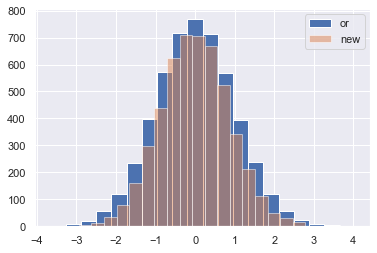

In [66]:
plt.hist(M[:, 0], bins=20, label='or');
plt.hist(ICA.inverse_transform(B)[:, 0], bins=20, label='new', alpha=0.5);
plt.legend()
print(pearsonr(M[:, 0],ICA.inverse_transform(B)[:, 0] ))

(0.30111791615551636, 0.022837973503920733)


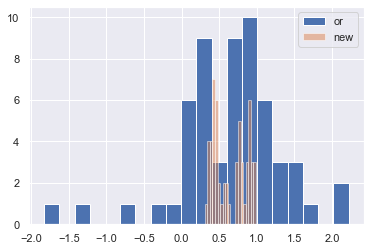

In [67]:
plt.hist(M[0, :], bins=20, label='or');
plt.hist(ICA.inverse_transform(B)[0, :], bins=20, label='new', alpha=0.5);
plt.legend()
print(pearsonr(M[0, :],ICA.inverse_transform(B)[0, :] ))

# PCA-ICA Single Run

In [68]:
_, s, vh = linalg.svd(M, full_matrices=False)

Text(0, 0.5, 'Percentage (%) Variance')

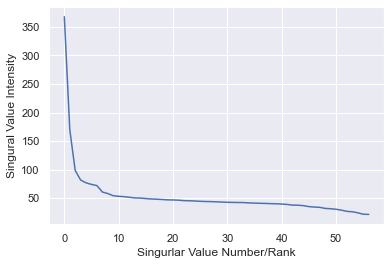

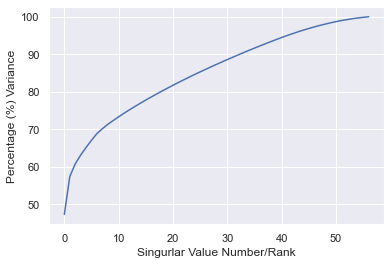

In [69]:
plt.figure()
plt.plot(s)
plt.xlabel('Singurlar Value Number/Rank')
plt.ylabel('Singural Value Intensity')

plt.figure()
plt.plot(np.cumsum(s**2)*100 / np.sum(s**2))    
plt.xlabel('Singurlar Value Number/Rank')
plt.ylabel('Percentage (%) Variance')

In [16]:
k_ranked_component=20
if k_ranked_component is not None:
    vh_k = vh[:k_ranked_component, :]
else:
    vh_k = vh

In [17]:
ICA = FastICA(
    n_components = 5,
    tol = 1e-13,
    max_iter = 3000,   
)
ICA.fit(vh_k)
G = ICA.mixing_.T
B = ICA.transform(vh_k)
print('Vh_K shape: {}, B shape: {}, G shape: {}'.format(vh_k.shape, B.shape, G.shape))

Vh_K shape: (20, 57), B shape: (20, 5), G shape: (5, 57)


# PCA-ICA at multiple dimensionalities

```octave

% if Jvalues is a single negative value, just run ICA once for this value.

CorrThresh=0.9;
RepeatsPerJ=10; % 10
g='tanh'; %g='pow3';
epsilon=1e-13;
DoPass2=1;

%%% first-pass: compare a range of dimensionalities
[pcaU,pcaS,pcaV]=nets_svds(X,max(Jvalues));
NStrongCorrs=[];
for J=Jvalues
  grot2=[];
  for JJ=1:RepeatsPerJ
    grot=randn(size(X,1),1)>0;  [pcaU1,pcaS1,pcaV1]=nets_svds(X(grot==0,:),J);  [pcaU2,pcaS2,pcaV2]=nets_svds(X(grot==1,:),J);
    [icaS,icaA,~]   = fastica(pcaV(:,1:J)', 'approach','symm','g',g,'epsilon',epsilon,'maxNumIterations',3000,'lastEig',J);
    [icaS1,icaA1,~] = fastica(pcaV1',       'approach','symm','g',g,'epsilon',epsilon,'maxNumIterations',3000,'lastEig',J);
    [icaS2,icaA2,~] = fastica(pcaV2',       'approach','symm','g',g,'epsilon',epsilon,'maxNumIterations',3000,'lastEig',J);
    [grotA,grotB,grotC,grotD,grotE,grotF] = ssorder2(icaS',icaA',icaS1',icaA1',icaS2',icaA2');
    icaS=grotA';icaA=grotB';icaS1=grotC';icaA1=grotD';icaS2=grotE';icaA2=grotF';
    grot=corr([icaS' icaS1' icaS2']);  % figure; imagesc(grot,[-1 1]); figure;plot(diag(grot(J+1:2*J,2*J+1:end))');
    grot2=[grot2;diag(grot(J+1:2*J,2*J+1:end))'];
  end;
  figure; plot(grot2'+randn(size(grot2'))*0.001); hold on; plot(mean(grot2)','k','LineWidth',2); title(sprintf('J=%d',J)); drawnow;
  NStrongCorrs=[NStrongCorrs sum(mean(grot2)>CorrThresh)];
end;
figure; plot(Jvalues,NStrongCorrs); drawnow; NStrongCorrs

```

In [31]:
### TODO - CHECK THESE FUNCTIONS WITH REAL DATA (REAL Bs and Gs) in MATLAB

def ssorder(Aref, Ain, Sin):

    N = Aref.shape[1]
    Nin = Ain.shape[1]
    
    grot = np.abs(Aref.T.dot(Ain))

    grotii = []
    grotjj = []

    for ss in range(min(N,Nin)):
        grotm=np.max(grot)
        ii, jj = np.where(grot==grotm)
        grotii.append(int(ii))
        grotjj.append(int(jj))
        grot[ii, :] = 0
        grot[:, jj] = 0

    yy, ii = np.sort(grotii), np.argsort(grotii)
    grotjj = list(np.array(grotjj)[ii])
    Aout = Ain[:, grotjj]
    Sout = Sin[grotjj, :]

    grot = Aref[:, yy].T.dot(Aout)
    grot = np.sign(np.diag(grot))

    Aout = Aout * np.tile(grot, (Ain.shape[0], 1))
    Sout = Sout * np.tile(grot, (Sin.shape[1], 1)).T

    return Aout, Sout

def ssorder2(AinRef, SinRef, Ain1, Sin1, Ain2, Sin2):

    Aout1, Sout1 = ssorder(AinRef, Ain1, Sin1)
    Aout2, Sout2 = ssorder(AinRef, Ain2, Sin2)

    ii = Aout1.shape[1]
    grot = np.corrcoef(np.concatenate((Aout1, Aout2), axis=1), rowvar=False)
    grot = np.diag(grot[0:ii, ii:])

    yy, ii = np.flip(np.sort(grot)), np.flip(np.argsort(grot))

    AoutRef=AinRef[:,ii]
    SoutRef=SinRef[ii,:]
    Aout1=Aout1[:,ii]
    Sout1=Sout1[ii,:]
    Aout2=Aout2[:,ii]
    Sout2=Sout2[ii,:]

    return AoutRef, SoutRef, Aout1, Sout1, Aout2, Sout2

In [32]:
M.shape

(5022, 57)

<ipython-input-35-ef27c32873ae>:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


[0, 1, 1, 2, 2, 4, 3, 5, 6, 0, 7, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 4, 11, 9, 9, 11, 10, 8, 17, 15, 14, 16, 15, 16, 16, 16, 19, 18, 20, 18, 20, 19, 20, 21, 20, 20, 21, 16, 14, 17, 13, 12, 7, 5]


Text(0, 0.5, 'Number of Strong Correlations / Number of components')

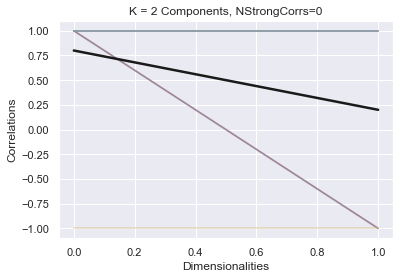

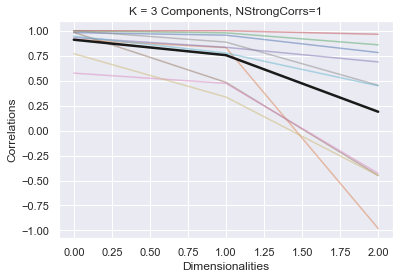

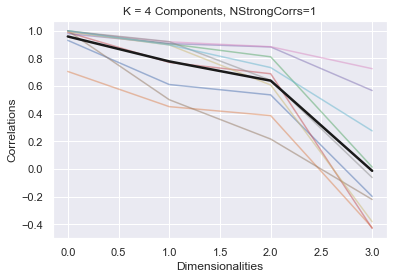

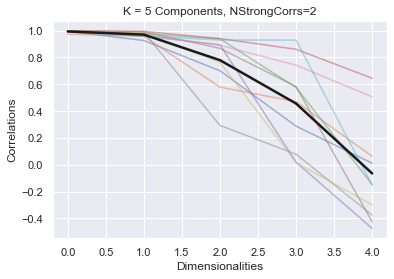

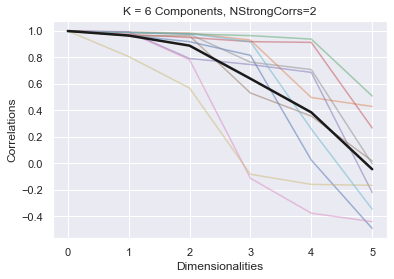

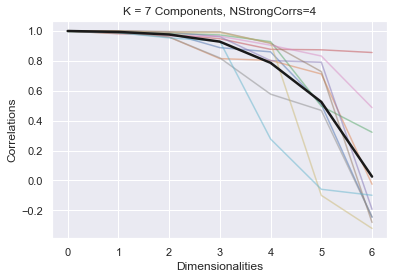

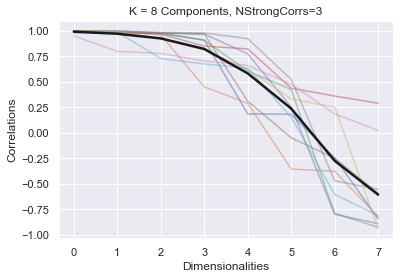

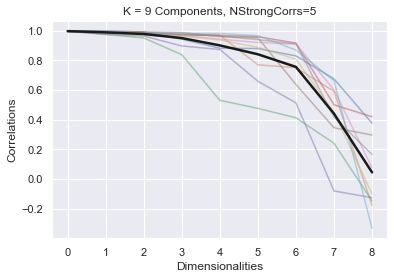

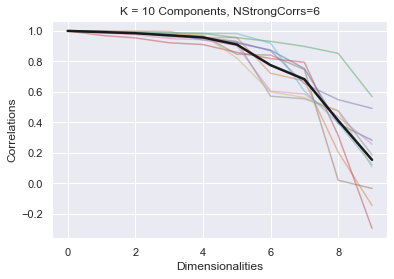

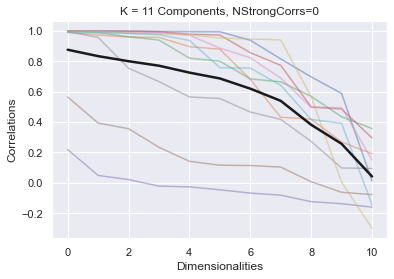

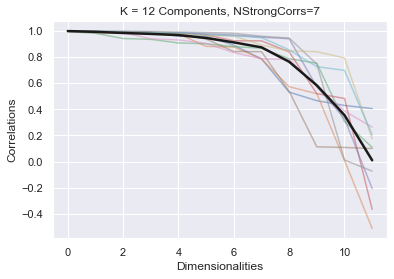

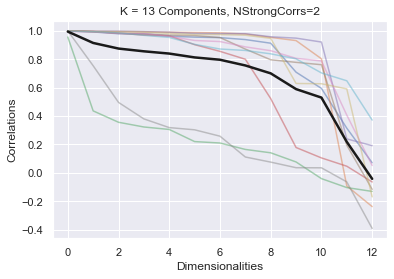

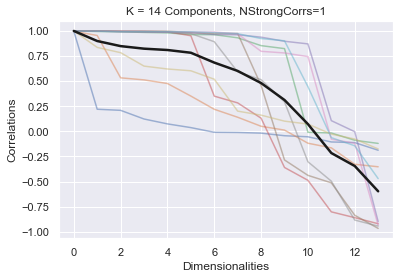

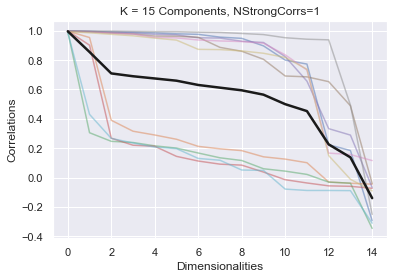

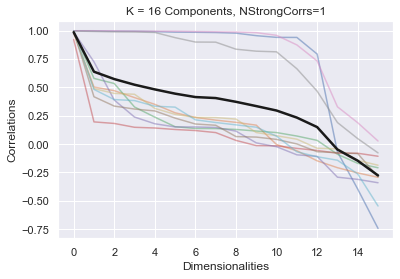

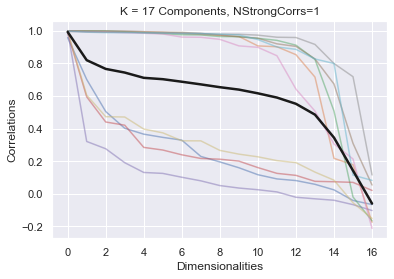

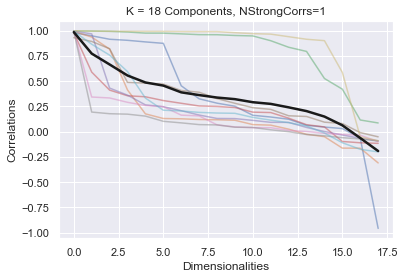

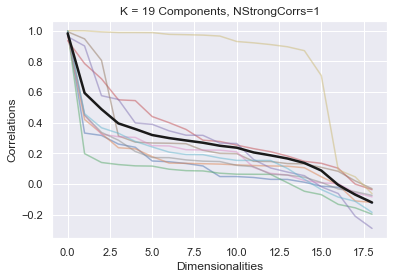

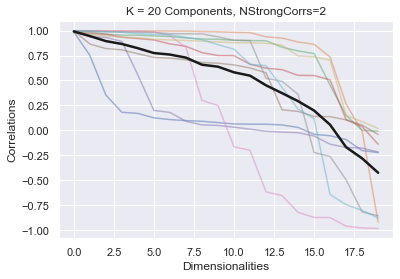

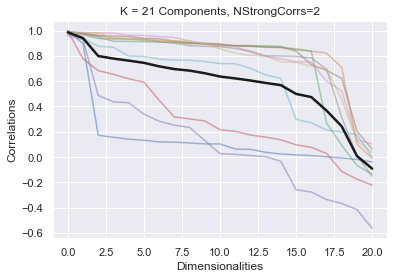

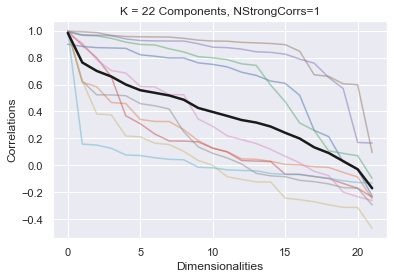

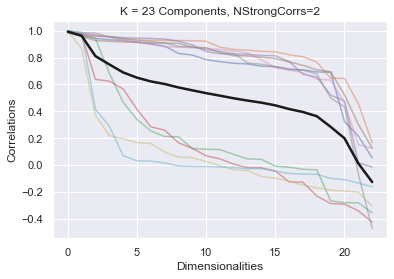

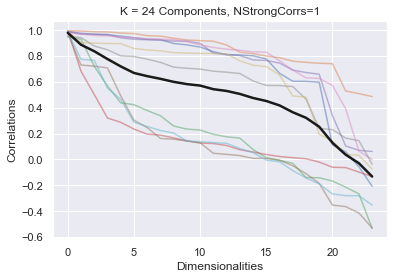

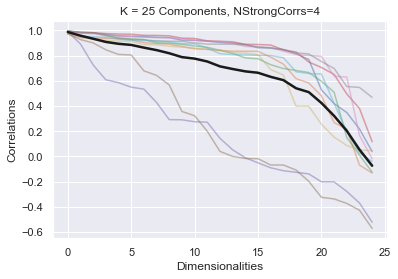

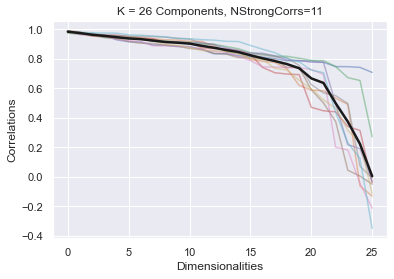

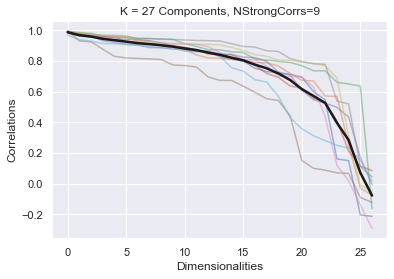

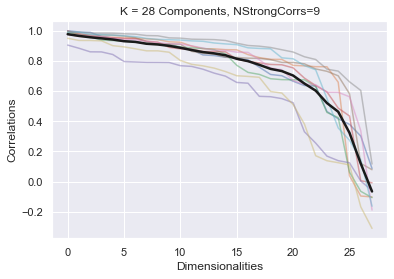

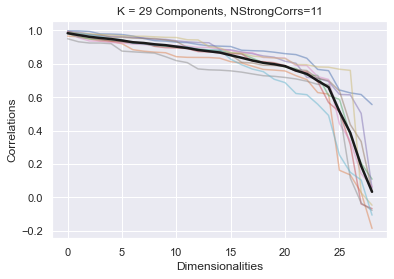

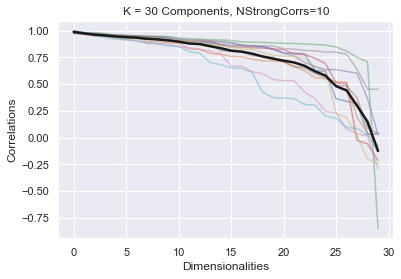

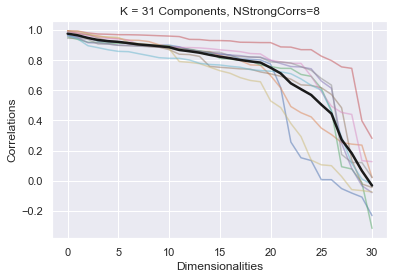

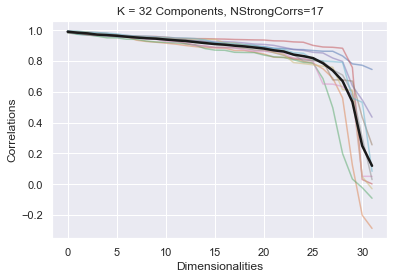

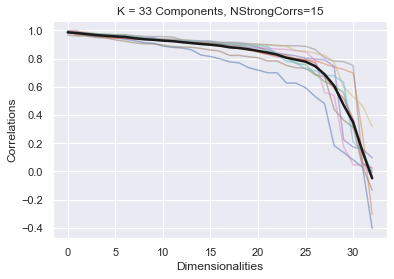

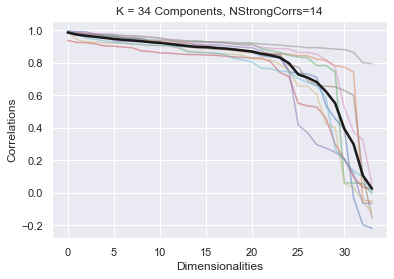

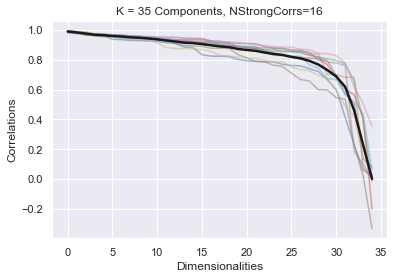

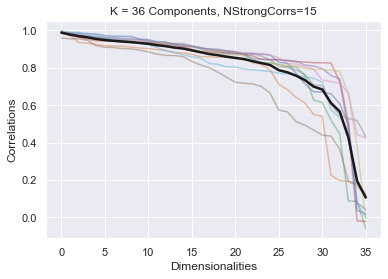

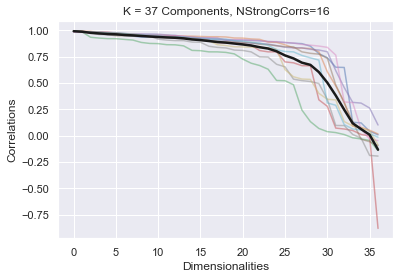

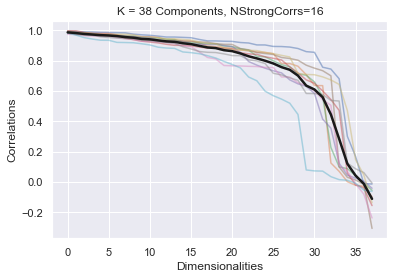

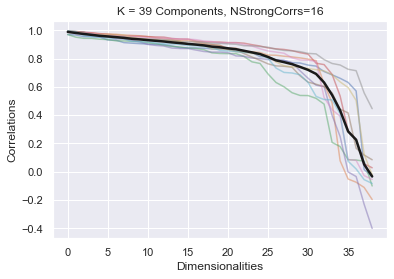

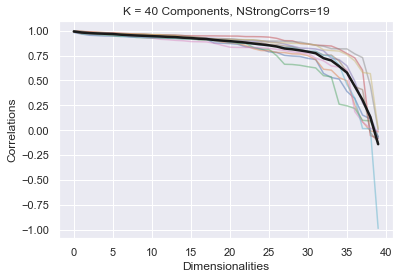

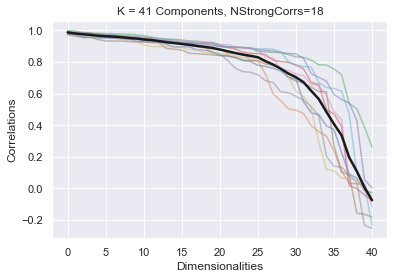

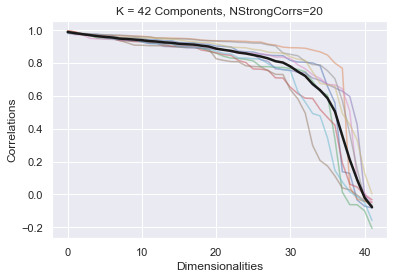

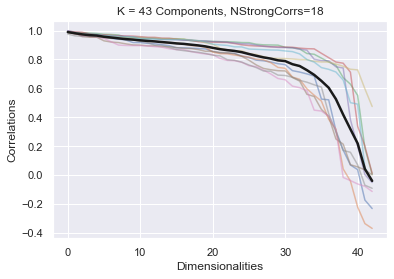

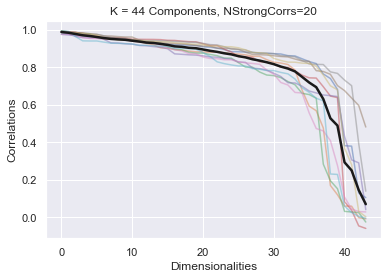

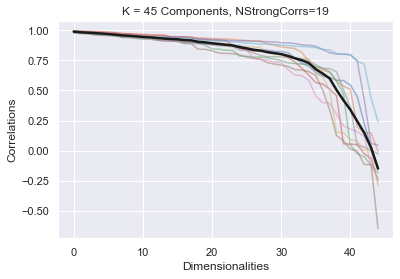

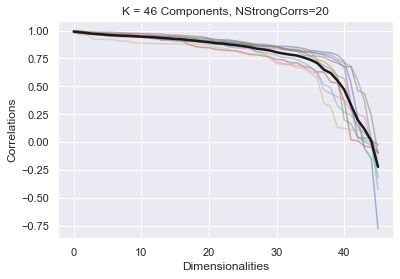

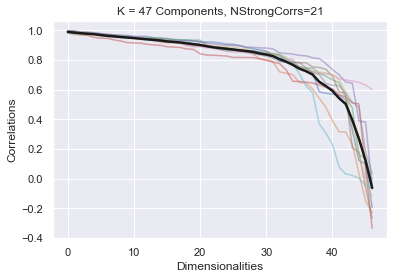

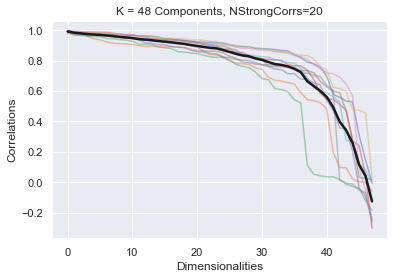

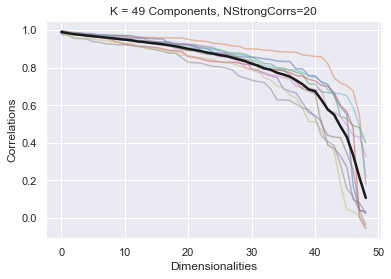

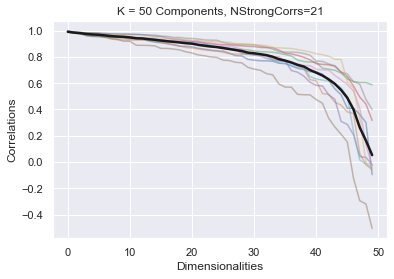

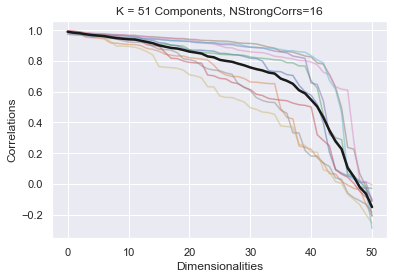

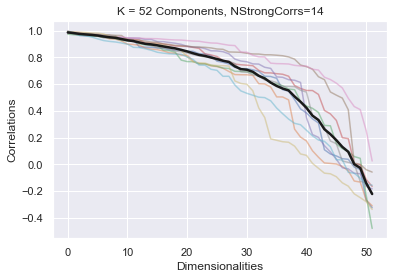

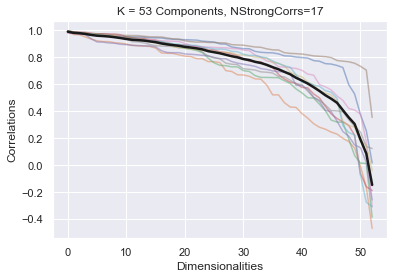

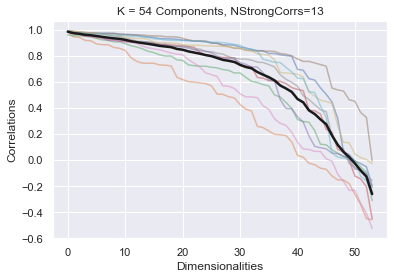

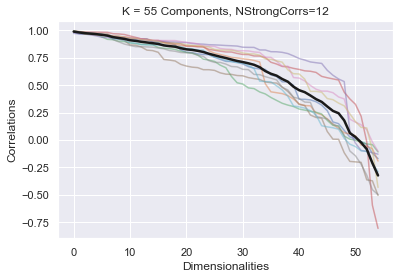

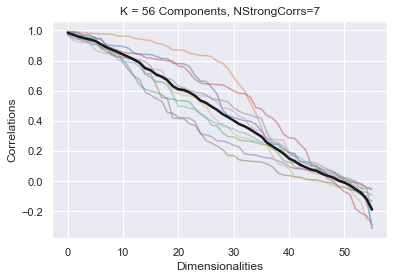

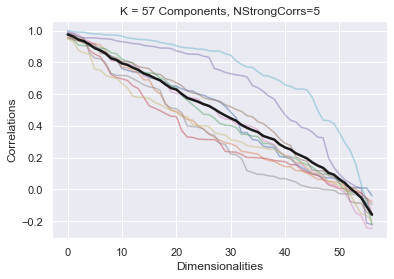

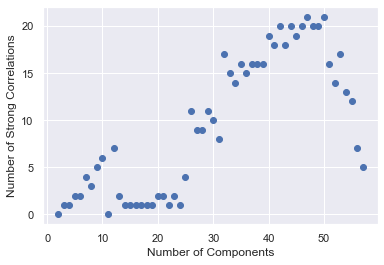

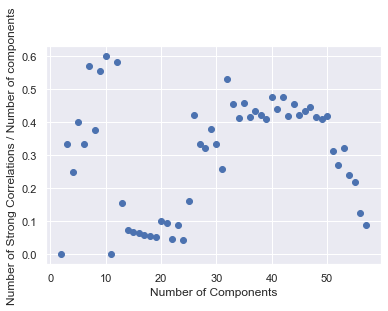

In [35]:
correlation_threshold = 0.9
repeats_per_k_value = 10

# First Pass: Compare a range of dimensionalities
u, s, vh = linalg.svd(M, full_matrices=False)
k_values = np.array(range(s.shape[0])) + 1
k_values = k_values[1:]

NStrongCorrs = []

# k_values = [44]

for k in k_values:
    vh_k = vh[:k, :]
    print(shape(vh_k))
    correlation_list = []
    for _ in range(repeats_per_k_value):
        
        random_split = np.random.randn(M.shape[0]) > 0
        
        u1, s1, vh1 = linalg.svd(M[random_split], full_matrices=False)
        u2, s2, vh2 = linalg.svd(M[~random_split], full_matrices=False)
        vh1_k, vh2_k = vh1[:k, :], vh2[:k, :]
        

        
        ICA = FastICA(tol = 1e-13, max_iter = 3000, algorithm='deflation', fun='cube' )
        ICA1 = FastICA(tol = 1e-13, max_iter = 3000, algorithm='deflation', fun='cube' )
        ICA2 = FastICA(tol = 1e-13, max_iter = 3000, algorithm='deflation', fun='cube' )
#         ICA = FastICA(tol = 1e-13, max_iter = 3000) 
#         ICA1 = FastICA(tol = 1e-13, max_iter = 3000)
#         ICA2 = FastICA(tol = 1e-13, max_iter = 3000)
        ICA.fit(vh_k)
        ICA1.fit(vh1_k)
        ICA2.fit(vh2_k)        
        G = ICA.mixing_.T
        G1 = ICA1.mixing_.T
        G2 = ICA2.mixing_.T
        B = ICA.transform(vh_k)
        B1 = ICA1.transform(vh1_k)
        B2 = ICA2.transform(vh2_k)
        
        B, G, B1, G1, B2, G2 = ssorder2(B.T, G.T, B1.T, G1.T, B2.T, G2.T)
        B, G, B1, G1, B2, G2 = B.T, G.T, B1.T, G1.T, B2.T, G2.T
        
#         icaA = u[:k, :].dot()
    
    
        correlations = np.corrcoef(np.hstack((B.T, B1.T, B2.T)),rowvar=False)
#         print(correlations.shape)
        correlation_list.append(np.diag(correlations[k:2*k, 2*k:]))
        
    correlation_list = np.array(correlation_list)
    nsc = np.sum(np.mean(correlation_list, axis=0) > correlation_threshold)
    NStrongCorrs.append(nsc)
       
    plt.figure()
    plt.plot(correlation_list.T, alpha=0.5) # + np.random.normal(size=correlation_list.T.shape)*0.001)
    plt.plot(np.mean(correlation_list, axis=0), color='k', linewidth=2.5)
    plt.title('K = {} Components, NStrongCorrs={}'.format(k, nsc))
    plt.xlabel('Dimensionalities')
    plt.ylabel('Correlations')

#     print('k={}, correlation_list={}'.format(k, correlation_list))
    
plt.figure()
plt.scatter( k_values, NStrongCorrs)
plt.xlabel('Number of Components')
plt.ylabel('Number of Strong Correlations')
print(NStrongCorrs)

plt.figure()
plt.scatter( k_values, np.divide(NStrongCorrs, k_values))
plt.xlabel('Number of Components')
plt.ylabel('Number of Strong Correlations / Number of components')

In [36]:
vh_k.shape

(57, 57)

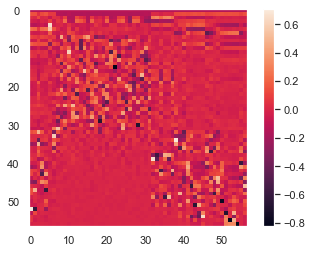

In [41]:
plt.imshow(vh_k)
plt.grid(False)
plt.colorbar()

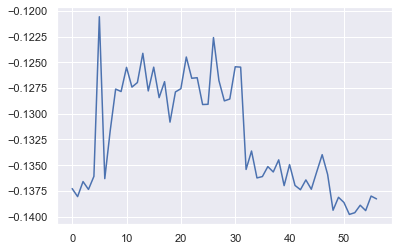

In [42]:
plt.plot(vh_k[0])

In [20]:
k = k_values[np.where(NStrongCorrs == np.amax(NStrongCorrs))][0]
NStrongCorrs = np.array(NStrongCorrs)
number_aim_to_keep = NStrongCorrs[np.where(NStrongCorrs == np.amax(NStrongCorrs))][0]
correlation_list = []
correlation_idx = -1

print('PCA-K = {}, ICA-N = {}'.format(k_values[np.where(NStrongCorrs == np.amax(NStrongCorrs))][0], NStrongCorrs[np.where(NStrongCorrs == np.amax(NStrongCorrs))][0]))

vh_k = vh[:k, :]

PCA-K = 44, ICA-N = 21


In [19]:
G.shape

(57, 57)

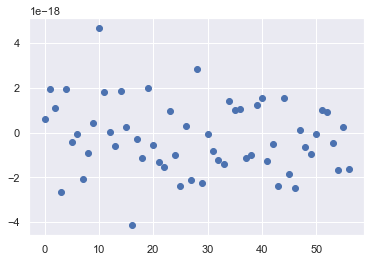

In [20]:
plt.scatter(np.arange(0, G.shape[0]), G[0,:])

* for 20 repeats per K each: PCA-K = 53, ICA-N = 29
* for 40 repeats per K each: PCA-K = 47, ICA-N = 28
* for 60 repeats per K each: PCA-K = 48, ICA-N = 27
* for 60 repeats per K each: PCA-K = 44, ICA-N = 22 (repeat 2)
* for 100 repeats per K each: PCA-K = 47, ICA-N = 22
* for 100 repeats per K each: PCA-K = 44, ICA-N = 22 (repeat 2)
* for 100 repeats per K each:PCA-K = 44, ICA-N = 21 (repeat 3)

In [20]:
for _ in range(repeats_per_k_value * 3):

    random_split = np.random.randn(M.shape[0]) > 0

    _, _, vh1 = linalg.svd(M[random_split], full_matrices=False)
    _, _, vh2 = linalg.svd(M[~random_split], full_matrices=False)
    vh1_k, vh2_k = vh1[:k, :], vh2[:k, :]

    ICA = FastICA(tol = 1e-13, max_iter = 3000, algorithm='deflation', fun='cube' )
    ICA1 = FastICA(tol = 1e-13, max_iter = 3000, algorithm='deflation', fun='cube' )
    ICA2 = FastICA(tol = 1e-13, max_iter = 3000, algorithm='deflation', fun='cube' )
    ICA.fit(vh_k)
    ICA1.fit(vh1_k)
    ICA2.fit(vh2_k)        
    G = ICA.mixing_.T
    G1 = ICA1.mixing_.T
    G2 = ICA2.mixing_.T
    B = ICA.transform(vh_k)
    B1 = ICA1.transform(vh1_k)
    B2 = ICA2.transform(vh2_k)

    B, G, B1, G1, B2, G2 = ssorder2(B.T, G.T, B1.T, G1.T, B2.T, G2.T)
    B, G, B1, G1, B2, G2 = B.T, G.T, B1.T, G1.T, B2.T, G2.T

    correlations = np.corrcoef(np.hstack((B.T, B1.T, B2.T)),rowvar=False)
    correlation_list.append(np.mean(np.diag(correlations[k:k+number_aim_to_keep, 2*k:2*k+number_aim_to_keep])))
        
    if correlation_list[-1] > correlation_idx:
        correlation_idx = correlation_list[-1]
        Gout = G[:, 0:number_aim_to_keep]
        Bout = B[0:number_aim_to_keep, :]
        
B = np.copy(Bout)
G = np.copy(Gout)

PCA-K = 47, ICA-N = 28


KeyboardInterrupt: 

In [ ]:
plt.hist(correlation_list, bins=30);

In [ ]:
plt.scatter(np.arange(0, len(correlation_list), 1), correlation_list)

In [19]:
np.arange(0, correlation_list, 1).

(2522, 57)

In [20]:
M[~random_split].shape

(2500, 57)

In [22]:
~random_split

array([ True, False, False, ...,  True,  True, False])

0:00:39.739588


In [24]:
B.shape

(56, 56)

In [25]:
G.shape

(56, 57)

In [26]:
k = 3
vh_k = vh[:k, :]

ICA = FastICA(n_components = k, tol = 1e-13, max_iter = 20000 )
ICA.fit(vh_k)
print(ICA.n_iter_)

49


In [27]:
k = 4
vh_k = vh[:k, :]

ICA = FastICA(n_components = k, tol = 3e-1, max_iter = 20000 )
ICA.fit(vh_k)
print(ICA.n_iter_)

20000


/Users/andreiroibu/opt/anaconda3/envs/agemapper/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


In [28]:
k = 5
vh_k = vh[:k, :]

ICA = FastICA(tol = 6e-1, max_iter = 20000)
ICA.fit(vh_k)
print(ICA.n_iter_)

1


In [29]:
k = 5
vh_k = vh[:k, :]

ICA = FastICA(tol = 1e-13, max_iter = 20000, algorithm='deflation' )
ICA.fit(vh_k)
print(ICA.n_iter_)

20


In [30]:
k = 10
vh_k = vh[:k, :]

ICA = FastICA(tol = 1e-13, max_iter = 20000, algorithm='deflation' )
ICA.fit(vh_k)
print(ICA.n_iter_)

100


In [31]:
k = 10
vh_k = vh[:k, :]

ICA = FastICA(tol = 1e-13, max_iter = 20000, algorithm='deflation' )
ICA.fit(vh_k)
print(ICA.n_iter_)

84


In [32]:
k = 20
vh_k = vh[:k, :]

ICA = FastICA(tol = 1e-13, max_iter = 20000, algorithm='deflation' )
ICA.fit(vh_k)
print(ICA.n_iter_)

20000


In [33]:
k = 40
vh_k = vh[:k, :]

ICA = FastICA(tol = 1e-13, max_iter = 20000, algorithm='deflation' )
ICA.fit(vh_k)
print(ICA.n_iter_)

496


In [34]:
k = 50
vh_k = vh[:k, :]

ICA = FastICA(tol = 1e-13, max_iter = 20000, algorithm='deflation' )
ICA.fit(vh_k)
print(ICA.n_iter_)

20000


In [29]:
n_max = 0
sum_iter = 0

for i in range(100):
    k = 50
    vh_k = vh[:k, :]

    ICA = FastICA(tol = 1e-13, max_iter = 3000, algorithm='deflation')
    ICA.fit(vh_k)

    if ICA.n_iter_ == 3000:
        n_max+=1
    
    sum_iter += ICA.n_iter_
    
print(n_max)
print(sum_iter/100)

29
1170.27


In [30]:
n_max = 0
sum_iter = 0

for i in range(100):
    k = 50
    vh_k = vh[:k, :]

    ICA = FastICA(tol = 1e-13, max_iter = 3000, algorithm='deflation', fun='cube' )
    ICA.fit(vh_k)

    if ICA.n_iter_ == 3000:
        n_max+=1
    
    sum_iter += ICA.n_iter_
    
print(n_max)
print(sum_iter/100)

7
299.44


In [31]:
n_max = 0
sum_iter = 0

for i in range(100):
    k = 50
    vh_k = vh[:k, :]

    ICA = FastICA(tol = 1e-13, max_iter = 3000, algorithm='deflation', fun='exp' )
    ICA.fit(vh_k)

    if ICA.n_iter_ == 3000:
        n_max+=1
    
    sum_iter += ICA.n_iter_
    
print(n_max)
print(sum_iter/100)

96
2908.78


In [38]:
k = 50
vh_k = vh[:k, :]

ICA = FastICA(tol = 1e-13, max_iter = 20000, algorithm='deflation', fun='cube' )
ICA.fit(vh_k)
print(ICA.n_iter_)

105


In [39]:
k = 50
vh_k = vh[:k, :]

ICA = FastICA(tol = 1e-13, max_iter = 20000, algorithm='deflation' )
ICA.fit(vh_k)
print(ICA.n_iter_)

626


In [40]:
ICA1 = FastICA(n_components = k, tol = 1e-13, max_iter = 3000 )
ICA1.fit(vh1_k)

FastICA(max_iter=3000, n_components=50, tol=1e-13)

In [82]:
# G = ICA.mixing_.T
# G1 = ICA1.mixing_.T
# G2 = ICA2.mixing_.T
# B = ICA.transform(vh_k)
# B1 = ICA1.transform(vh1_k)
# B2 = ICA2.transform(vh2_k)
AinRef = np.random.randn(9,10)
SinRef = np.random.randn(10,10)
Ain1 = np.random.randn(9,10)
Sin1 = np.random.randn(10,10)
Ain2 = np.random.randn(9,10)
Sin2 = np.random.randn(10,10)

from scipy.io import savemat
AinRef_dic = {'AinRef':AinRef, 'label':'AinRef'}
savemat("AinRef.mat", AinRef_dic)
SinRef_dic = {'SinRef':SinRef, 'label':'SinRef'}
savemat("SinRef.mat", SinRef_dic)

Aindic = {'Ain1':Ain1, 'label':'Ain1'}
savemat("Ain1.mat", Aindic)
Sindic = {'Sin1':Sin1, 'label':'Sin1'}
savemat("Sin1.mat", Sindic)

Aindic = {'Ain2':Ain2, 'label':'Ain2'}
savemat("Ain2.mat", Aindic)
Sindic = {'Sin2':Sin2, 'label':'Sin2'}
savemat("Sin2.mat", Sindic)


Aref.shape

(9, 10)

# ICA (no PCA) at multiple dimensionalities

In [33]:
### TODO - CHECK THESE FUNCTIONS WITH REAL DATA (REAL Bs and Gs) in MATLAB

def ssorder(Aref, Ain, Sin):

    N = Aref.shape[1]
    Nin = Ain.shape[1]
    
    grot = np.abs(Aref.T.dot(Ain))

    grotii = []
    grotjj = []

    for ss in range(min(N,Nin)):
        grotm=np.max(grot)
        ii, jj = np.where(grot==grotm)
        grotii.append(int(ii))
        grotjj.append(int(jj))
        grot[ii, :] = 0
        grot[:, jj] = 0

    yy, ii = np.sort(grotii), np.argsort(grotii)
    grotjj = list(np.array(grotjj)[ii])
    Aout = Ain[:, grotjj]
    Sout = Sin[grotjj, :]

    grot = Aref[:, yy].T.dot(Aout)
    grot = np.sign(np.diag(grot))

    Aout = Aout * np.tile(grot, (Ain.shape[0], 1))
    Sout = Sout * np.tile(grot, (Sin.shape[1], 1)).T

    return Aout, Sout

def ssorder2(AinRef, SinRef, Ain1, Sin1, Ain2, Sin2):

    Aout1, Sout1 = ssorder(AinRef, Ain1, Sin1)
    Aout2, Sout2 = ssorder(AinRef, Ain2, Sin2)

    ii = Aout1.shape[1]
    grot = np.corrcoef(np.concatenate((Aout1, Aout2), axis=1), rowvar=False)
    grot = np.diag(grot[0:ii, ii:])

    yy, ii = np.flip(np.sort(grot)), np.flip(np.argsort(grot))

    AoutRef=AinRef[:,ii]
    SoutRef=SinRef[ii,:]
    Aout1=Aout1[:,ii]
    Sout1=Sout1[ii,:]
    Aout2=Aout2[:,ii]
    Sout2=Sout2[ii,:]

    return AoutRef, SoutRef, Aout1, Sout1, Aout2, Sout2

In [32]:
correlation_threshold = 0.9
repeats_per_k_value = 1

NStrongCorrs = []

correlation_list = []
for _ in range(repeats_per_k_value):

    random_split = np.random.randn(M.shape[0]) > 0
    
    M1 = np.copy(M[random_split])
    M2 = np.copy(M[~random_split])

    ICA = FastICA(tol = 1e-13, max_iter = 3000, algorithm='deflation', fun='cube' )
    ICA1 = FastICA(tol = 1e-13, max_iter = 3000, algorithm='deflation', fun='cube' )
    ICA2 = FastICA(tol = 1e-13, max_iter = 3000, algorithm='deflation', fun='cube' )
    ICA.fit(M)
    ICA1.fit(M1)
    ICA2.fit(M2)        
    G = ICA.mixing_.T
    G1 = ICA1.mixing_.T
    G2 = ICA2.mixing_.T
    B = ICA.transform(M)
    B1 = ICA1.transform(M1)
    B2 = ICA2.transform(M2)

    B, G, B1, G1, B2, G2 = ssorder2(B.T, G.T, B1.T, G1.T, B2.T, G2.T)
    B, G, B1, G1, B2, G2 = B.T, G.T, B1.T, G1.T, B2.T, G2.T

    correlations = np.corrcoef(np.hstack((B.T, B1.T, B2.T)),rowvar=False)
    
    print(correlations.shape)
    
    correlation_list.append(np.diag(correlations[k:2*k, 2*k:]))

correlation_list = np.array(correlation_list)
nsc = np.sum(np.mean(correlation_list, axis=0) > correlation_threshold)
NStrongCorrs.append(nsc)

plt.figure()
plt.plot(correlation_list.T) # + np.random.normal(size=correlation_list.T.shape)*0.001)
plt.plot(np.mean(correlation_list, axis=0), color='k', linewidth=2.5)
plt.title('K = {} Components, NStrongCorrs={}'.format(k, nsc))
plt.xlabel('Dimensionalities')
plt.ylabel('Correlations')
    
plt.figure()
plt.scatter( k_values, NStrongCorrs)
plt.xlabel('Number of Components')
plt.ylabel('Number of Strong Correlations')
print(NStrongCorrs)

plt.figure()
plt.scatter( k_values, np.divide(NStrongCorrs, k_values))
plt.xlabel('Number of Components')
plt.ylabel('Number of Strong Correlations / Number of components')

IndexError: index 328 is out of bounds for axis 0 with size 57

In [ ]:
{'Alcohol',
 'Blood Assays',
 'Cardiac & Circulartory Measurements',
#  'Cognitive Tests',
 'Diet',
#  'Eye Test',
 'Medical History',
 'Physical Measurements',
#  'Physical Test',
 'Skeletal Measurements',
 'Tobacco'}

In [ ]:
{'Cardiac & Circulartory Measurements',
 'Lifestyle',
 'Medical History',
 'Skeletal Measurements'}